# <center>Fetal Health Classification</center>

In [1]:
#  basics
import numpy as np
import pandas as pd
from tqdm import tqdm 
import warnings

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable  # pip install prettytable 
plt.style.use('fivethirtyeight')

# EDA & Feature Selection
from imblearn.over_sampling import SMOTE # !pip install -U imbalanced-learn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# modeling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# database connection
# import sqlalchemy as db
# ip = ''
# port = ''
# db_name = ''
# username = ''
# password = ''
# conn = db.create_engine(f"postgresql://{username}:{password}@{ip}:{port}/{db_name}") # online db

# 1. Data
### 1.1. Info
Data is result of Cardiotocograms (CTGs) readings, it has **21 Features** as float data type and **1 Target** which represent fetal_health. Target (fetal_health) contains 3 classes as flollows 1.0 represents Normal, 2.0 represent Suspect, and 3.0 represent Pathological. [SOURCE](https://www.kaggle.com/andrewmvd/fetal-health-classification)

### 1.2. Loading Data

**Read .csv** from local machine

In [2]:
df = pd.read_csv("fetal_health.csv")
df['fetal_health'] = df['fetal_health'].replace(1, 'Normal')
df['fetal_health'] = df['fetal_health'].replace(2, 'Suspect')
df['fetal_health'] = df['fetal_health'].replace(3, 'Pathological')
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,Suspect
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,Normal
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,Normal
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,Normal
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,Suspect
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,Suspect
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,Suspect
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,Suspect


**Write to Database (Once)** so that we can read from remote database every time we need to run this code

In [3]:
# df.to_sql(name='fetal_health', con=conn, index=False)
# TODO

**Read from Database** directly without needing to provide local dataset

In [4]:
# df = pd.read_sql('select * from fetal_health', conn)
# TODO

# 2. EDA

**Correlation :** 

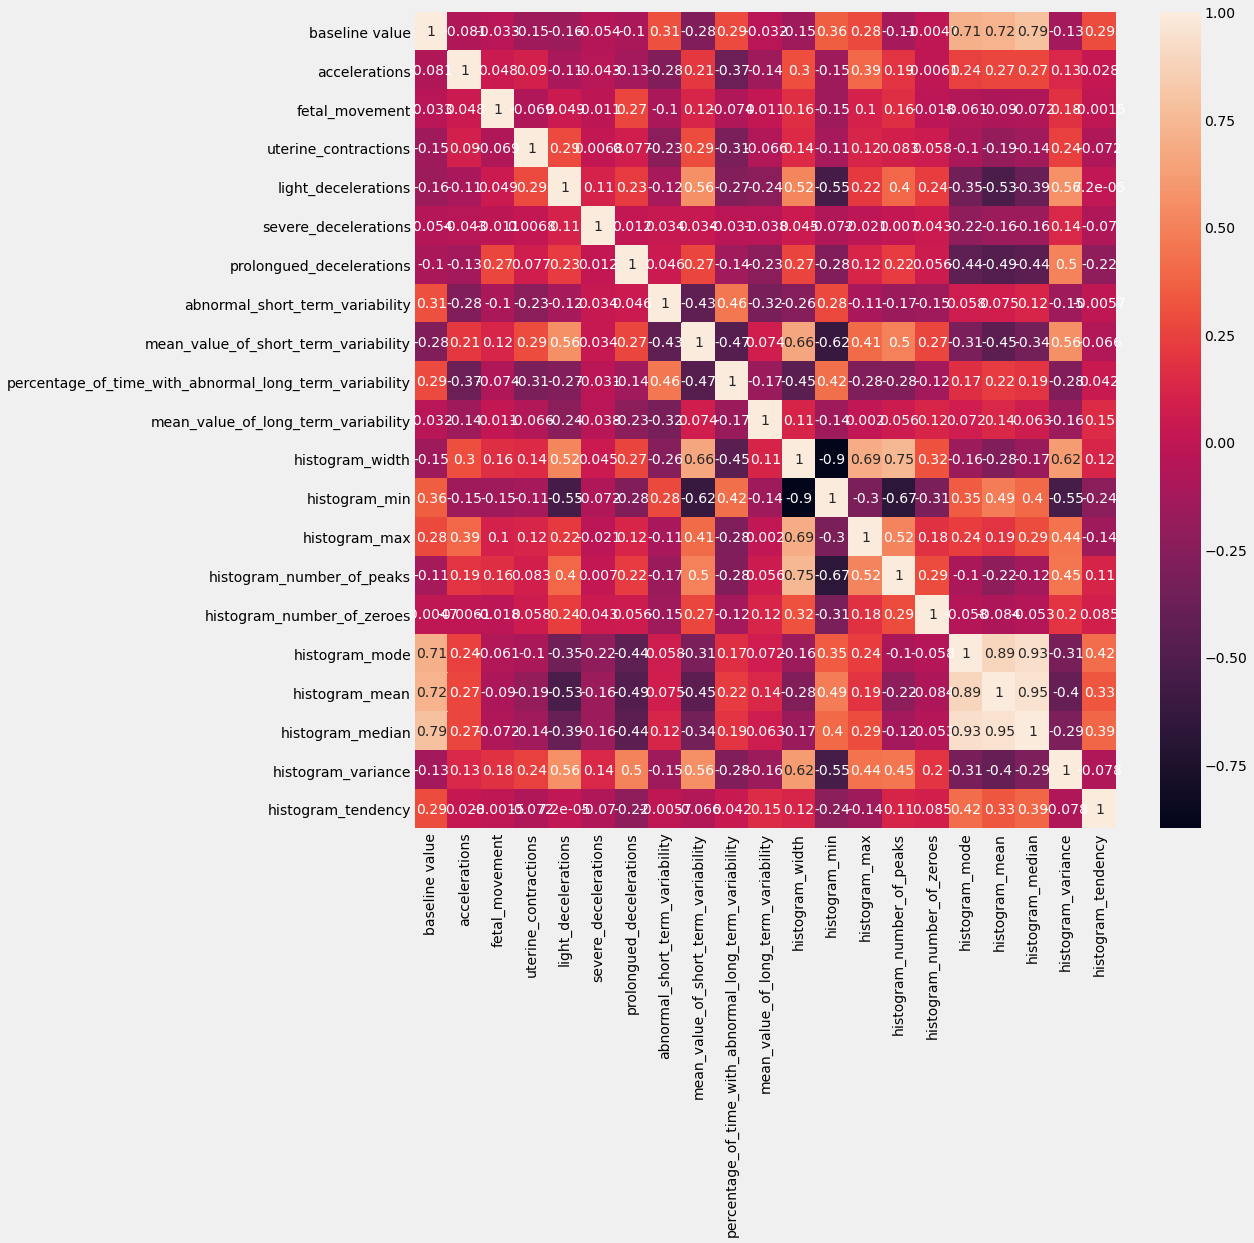

In [5]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(), annot=True);

**Classes Distribution :** high imbalance data

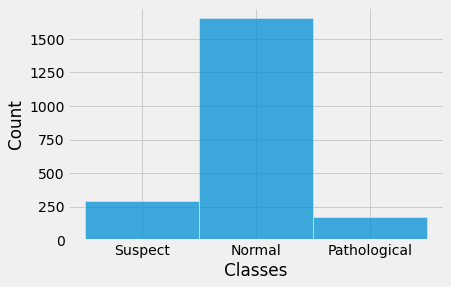

In [6]:
sns.histplot(df["fetal_health"]).set(xlabel='Classes', ylabel='Count');

**Oversampling :** using SMOTE to fix imbalance data

In [7]:
# Balance data using SMOTE
X, y = SMOTE(random_state=42).fit_resample(df.drop("fetal_health", axis=1), df["fetal_health"])
X['fetal_health'] = y
df = X.copy()

**Classes Distribution :** data is balanced now!

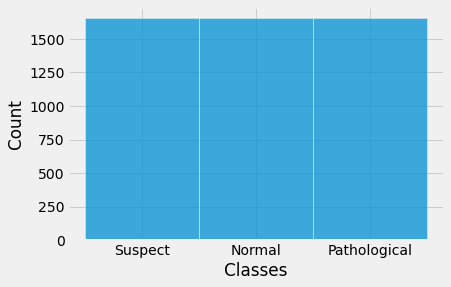

In [8]:
# classes distribution
sns.histplot(df['fetal_health'])\
.set(xlabel='Classes', ylabel='Count');

**Pairplot** shows the relationship between each feature and the others with respect to the target, also provide information about how likely each feature can distinguish target classes apart from from each other

In [9]:
# pairplot
# sns.pairplot(df, hue='fetal_health');

**Missing Values & Duplicates** : found 0 missing values and ~22 duplicated rows

In [10]:
# misssing values and duplicates
print(f'Number of missing values is {df.isna().sum().sum()}\nNumber of duplicated rows is {df.duplicated().sum()}')

Number of missing values is 0
Number of duplicated rows is 22


In [11]:
# removing duplicates
df.drop_duplicates(inplace=True)

**Normalization** Why do we use normalization? 
<ol>
  <li>Plot outliers togther in one chart 😇.</li>
  <li>Some algorithms are sensitive to the scale of the features (e.g. kNN, k-means and SVM) in the other hand some algorithems are NOT (e.g. tree-based algorithms). <a href='https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/'>source</a></li>
</ol>

In [12]:
# normalized_df=(df-df.mean())/df.std()
X_normalized = df.drop('fetal_health', axis=1)
df_normalized=(X_normalized-X_normalized.min())/(X_normalized.max()-X_normalized.min())
df_normalized['fetal_health'] = df['fetal_health']
df_normalized

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,0.259259,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.813333,0.044118,0.472527,...,0.110092,0.034483,0.111111,0.000000,0.472441,0.587156,0.403670,0.271375,1.000000,Suspect
1,0.481481,0.315789,0.000000,0.400000,0.200000,0.0,0.0,0.066667,0.279412,0.000000,...,0.165138,0.655172,0.333333,0.100000,0.637795,0.577982,0.577982,0.044610,0.500000,Normal
2,0.500000,0.157895,0.000000,0.533333,0.200000,0.0,0.0,0.053333,0.279412,0.000000,...,0.165138,0.655172,0.277778,0.100000,0.637795,0.568807,0.559633,0.048327,0.500000,Normal
3,0.518519,0.157895,0.000000,0.533333,0.200000,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.611111,0.000000,0.606299,0.559633,0.550459,0.048327,1.000000,Normal
4,0.481481,0.368421,0.000000,0.533333,0.000000,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.500000,0.000000,0.606299,0.577982,0.559633,0.040892,1.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,0.790050,0.000000,0.000000,0.489154,0.000000,0.0,0.0,0.479682,0.053951,0.208791,...,0.911351,0.399460,0.073964,0.000000,0.784933,0.795180,0.773791,0.003695,0.500000,Suspect
4961,0.565813,0.000000,0.019041,0.167864,0.000000,0.0,0.0,0.548784,0.044646,0.665033,...,0.747212,0.199514,0.055556,0.000000,0.618817,0.596989,0.574218,0.000000,0.500000,Suspect
4962,0.688455,0.030963,0.004077,0.360780,0.000000,0.0,0.0,0.621177,0.032296,0.329885,...,0.831264,0.356829,0.111111,0.000000,0.744943,0.732146,0.713797,0.004446,0.500000,Suspect
4963,0.641939,0.020485,0.026666,0.129740,0.000000,0.0,0.0,0.691098,0.020430,0.468250,...,0.750261,0.284483,0.111111,0.000000,0.669716,0.642696,0.624348,0.002271,0.500000,Suspect


**Outliers :** In our case outliers are part of the data, so no outliers removing!.

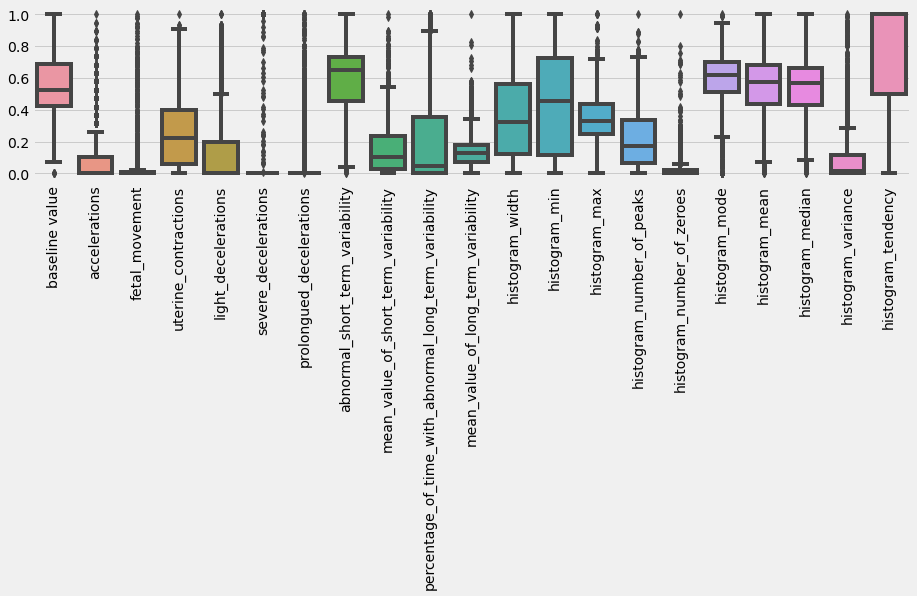

In [13]:
plt.figure(figsize=(14, 3))
sns.boxplot(data=df_normalized.drop('fetal_health', axis=1));
plt.xticks(rotation=90);

**Spliting Dataset**

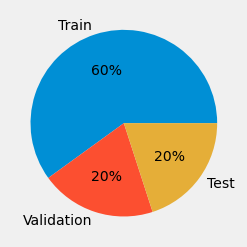

In [14]:
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

# create plot
plt.pie([X_train.shape[0], X_val.shape[0], X_test.shape[0]], 
        labels = ['Train', 'Validation', 'Test'], 
        autopct='%.0f%%')
plt.show()

# 3. Features Selection

### 3.1. **Method 1**
using Scikit Learn **SelectKBest** function which uses *f_classif()* (ANOVA) by default to calculate feature importance

In [15]:
# Calculate importances
f_importances_ANOVA = f_classif(X, y)[0]
f_importances_ANOVA_names = pd.DataFrame({'v':f_importances_ANOVA, 'n':X.columns}).sort_values('v')['n']

### 3.2. Method 2
RandomForest importance

In [16]:
# Calculate importances
f_importances_RF = RandomForestClassifier(n_estimators=100).fit(X_train,y_train).feature_importances_
f_importances_RF_names = pd.DataFrame({'v':f_importances_RF, 'n':X.columns}).sort_values('v')['n']

### 3.3. **Plot** Importances

In [17]:
# plot feature importance
def plot_feature_importance(title, values):
    plt.figure(figsize=(11, 3))
    labels = [str(i) for i in range(len(values))]
    values = np.interp(values, (values.min(), values.max()), (0, 1))
    ax = sns.barplot(data=pd.DataFrame({'values':values, 'names':labels}), 
                     x='names',
                     y='values');
    plt.suptitle(title);
    plt.xlabel('features');
    plt.ylabel('importance');
    plt.show();

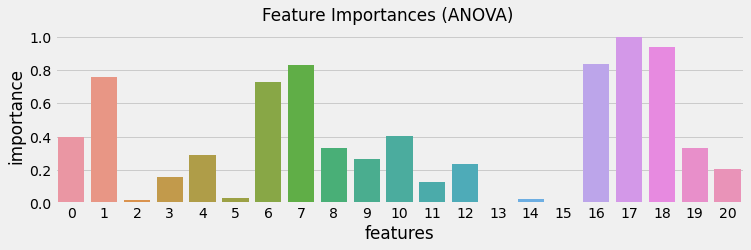

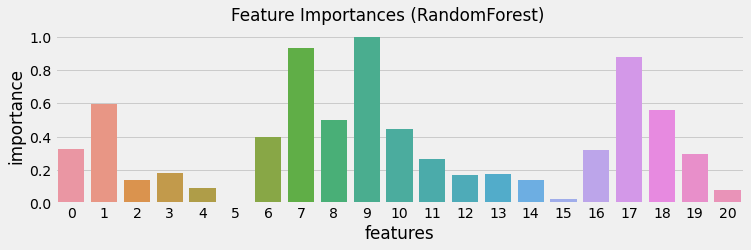

In [18]:
# plot
plot_feature_importance('Feature Importances (ANOVA)', values=f_importances_ANOVA)
# plot
plot_feature_importance('Feature Importances (RandomForest)', values=f_importances_RF)

# 4. Model Tuning & Validation

In [19]:
import matplotlib as mpl

# plotting 
def plot_model_results(values, labels=[]):
    if labels == [] : labels=range(len(values))
    plt.style.use('default')
    plt.figure(figsize=(11, 3))

    ax = sns.lineplot(data=pd.DataFrame(dict(zip(labels, values))))
    ax.set(xlabel='best k features', ylabel='evaluation values',
           xticks=np.arange(len(values[0])), yticks=np.arange(0.5,1.01,0.1))

    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='black', linewidth=0.25)
    ax.grid(b=True, which='minor', color='black', linewidth=0.05)
    
    plt.show();

### 4.1.Tuning Classifiers

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

def tunning_save_model(classifier, classifier_name, param_grid):

    # Create grid search object
    clf = GridSearchCV(classifier, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1)
    
    # Fit on data
    clf.fit(X_train, y_train)
    
    # save the model to disk
    joblib.dump(clf, classifier_name + '.sav')

In [21]:
warnings.filterwarnings("ignore")

# classifiers
classifiers = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(eval_metric='mlogloss')]

# classifiers names
classifiers_names = ['LR', 'RF', 'XGB']

# Create param grid.
param_grid = [
    {
        # LogisticRegression
        'penalty' : ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['liblinear']
    },
    {
        # RandomForest
        'n_estimators' : list(range(10,101,10)),
        'max_features' : list(range(3,21,5))
    },
    {
        # XGB
        'max_depth' : list(range(2,10,10)),
        'colsample_bytree' : list(np.arange(0.3,0.9,0.1)),
        'learning_rate' : list(np.arange(0.1,0.9,0.05))
    }
]

# finetune
for i, cl in enumerate(classifiers):
    tunning_save_model(cl, classifiers_names[i], param_grid[i])

### 4.2. Testing Classifiers

**Default** Classifiers

In [22]:
results_default = []
for c in classifiers:
    c.fit(X_train, y_train)
    results_default.append(c.score(X_test, y_test))

**Tuned** Classifiers

In [23]:
results_tunned = []
for cn in classifiers_names:
    loaded_model = joblib.load(cn + '.sav')
    results_tunned.append(loaded_model.score(X_test, y_test))

**Plot**

In [24]:
def plot_model_results(title, values):
    ax = sns.barplot(data=pd.DataFrame({'Classifier':classifiers_names,
                          'Score':values}),
           x='Classifier',
           y='Score')
    # ax.set_yticks(np.arange(0.5, 1.1, 0.1))
    plt.suptitle(title);
    ax.set_ybound(0.7, 1)
    plt.grid()
    plt.show();    

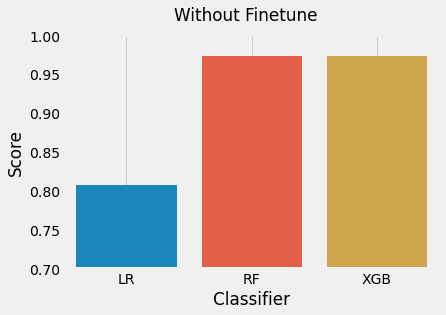

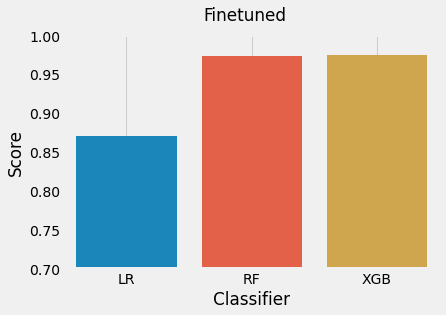

In [25]:
plot_model_results('Without Finetune', results_default)
plot_model_results('Finetuned', results_tunned)

### 4.3. Feaures Selection Test

In [26]:
import matplotlib as mpl
plt.style.use('default')

# plotting 
def plot_feature_selection_results(title, values, labels=[]):
    if labels == [] : labels=range(len(values))
    
#     plt.style.use('default')
    plt.figure(figsize=(11, 3))

    ax = sns.lineplot(data=pd.DataFrame(dict(zip(labels, values))))
    ax.set(xlabel='best k features', ylabel='evaluation values',
           xticks=np.arange(len(values[0])), yticks=np.arange(0.4, 1.01, 0.1))
    
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='black', linewidth=0.25)
    ax.grid(b=True, which='minor', color='black', linewidth=0.05)
    
    plt.legend(loc = 'lower right')
    plt.suptitle(title)
    plt.show();

**Plot**

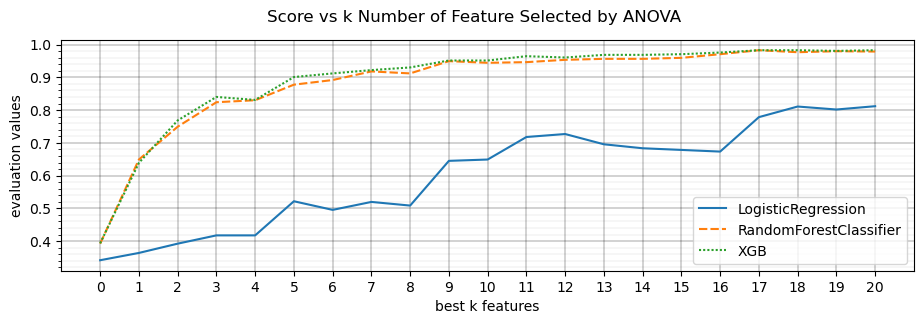

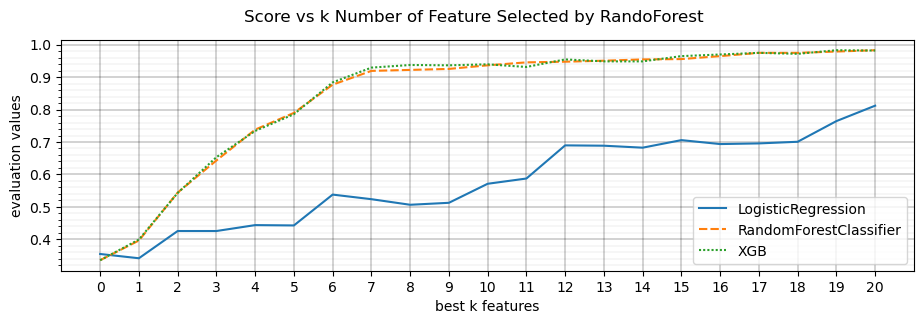

In [27]:
warnings.filterwarnings("ignore")
plt.style.use('default')

# ANOVA
values_list_ANOVA=[]
for c in classifiers:
    values = []
    for i in range(1, 21+1):
        cols = f_importances_ANOVA_names[:i]
        c.fit(X_train[cols], y_train)
        values.append(c.score(X_val[cols], y_val))
    values_list_ANOVA.append(values)
plot_feature_selection_results('Score vs k Number of Feature Selected by ANOVA', 
                               values_list_ANOVA, ['LogisticRegression', 'RandomForestClassifier', 'XGB'])

# RandomForest
values_list_RF=[]
for c in classifiers:
    values = []
    for i in range(1, 21+1):
        cols = f_importances_RF_names[:i]
        c.fit(X_train[cols], y_train)
        values.append(c.score(X_val[cols], y_val))
    values_list_RF.append(values)
plot_feature_selection_results('Score vs k Number of Feature Selected by RandoForest', 
                               values_list_RF, ['LogisticRegression', 'RandomForestClassifier', 'XGB'])

**Max Score** with k

In [28]:
# ANOVA
table = PrettyTable()
table.title = 'Best Score vs Number of Features by ANOVA'
a = np.array(values_list_ANOVA)
table.add_column('Classifier', classifiers_names)
table.add_column('Score', np.round(a.max(axis=1), 8))
table.add_column('Number of Features', a.argmax(axis=1))
print(table)

# RandomForest
table = PrettyTable()
table.title = 'Best Score vs Number of Features by RandomForest'
a = np.array(values_list_RF)
table.add_column('Classifier', classifiers_names)
table.add_column('Score', np.round(a.max(axis=1), 8))
table.add_column('Number of Features', a.argmax(axis=1))
print(table)

+----------------------------------------------+
|  Best Score vs Number of Features by ANOVA   |
+------------+------------+--------------------+
| Classifier |   Score    | Number of Features |
+------------+------------+--------------------+
|     LR     | 0.81193124 |         20         |
|     RF     | 0.98281092 |         17         |
|    XGB     | 0.98281092 |         17         |
+------------+------------+--------------------+
+-----------------------------------------------------+
|   Best Score vs Number of Features by RandomForest  |
+--------------+--------------+-----------------------+
|  Classifier  |    Score     |   Number of Features  |
+--------------+--------------+-----------------------+
|      LR      |  0.81193124  |           20          |
|      RF      |  0.98281092  |           20          |
|     XGB      |  0.98281092  |           19          |
+--------------+--------------+-----------------------+


- The most accurate models was Random forest and XGBoost with a difference of 0.002% on test set accuracy.
- It was observed that Randomforest needed 18 features to reach maximum accuracy , while XGBoost only needed 14.


# 5. Final Results

### 5.1. Confusion Metrics

In [29]:
# training final model
plt.style.use('default')

from sklearn import metrics
cols = f_importances_ANOVA_names[:13]
clf_final  = XGBClassifier(eval_metric='mlogloss')
clf_final.fit(X_train[cols], y_train)

clf_final.score(X_test[cols], y_test)
f1 =  f1_score(y_test,clf_final.predict(X_test[cols]),average='macro')
sc = clf_final.score(X_test[cols],y_test)
    #pr2 = precision_score()
pr= precision_score(y_test,clf_final.predict(X_test[cols]),average='macro')
re = recall_score(y_test,clf_final.predict(X_test[cols]),average='macro')
    #pr = precision_score(y_test,lm2.predict(X_scaledtest),average='samples')
    #re = recall_score(lm2.predict(X_scaledtest),y_test,average='samples')
ac = accuracy_score(clf_final.predict(X_test[cols]),y_test)
roc = roc_auc_score(y_test,clf_final.predict_proba(X_test[cols]),multi_class='ovo',average='macro') 

**Plot**

+--------------+--------------+
|    SCORER    |    VALUE     |
+--------------+--------------+
|   F1 Score   | 0.9646586464 |
|    Score     | 0.9635995956 |
|  Precission  | 0.964660909  |
|    Recall    | 0.9647869231 |
|   Accuracy   | 0.9635995956 |
| ROC over AUC | 0.9954891408 |
+--------------+--------------+


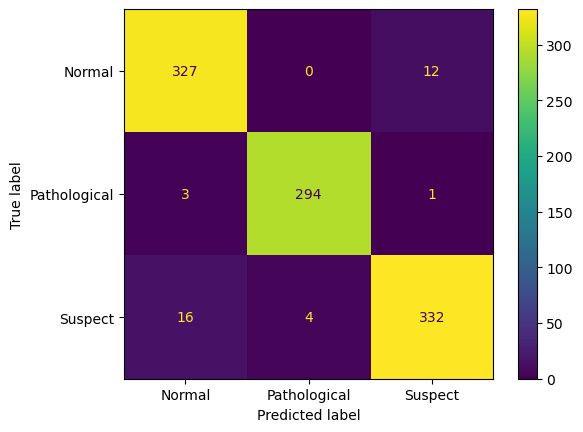

In [30]:
# print table
table = PrettyTable()
table.title = ''
table.add_column('SCORER', ['F1 Score', 'Score', 'Precission', 'Recall', 'Accuracy', 'ROC over AUC'])
table.add_column('VALUE', np.round([f1, sc, pr, re, ac, roc], 10))
print(table)

# plot
metrics.plot_confusion_matrix(clf_final, X_test[cols], y_test);

### 5.2. Examining probablities of misclassified predictions

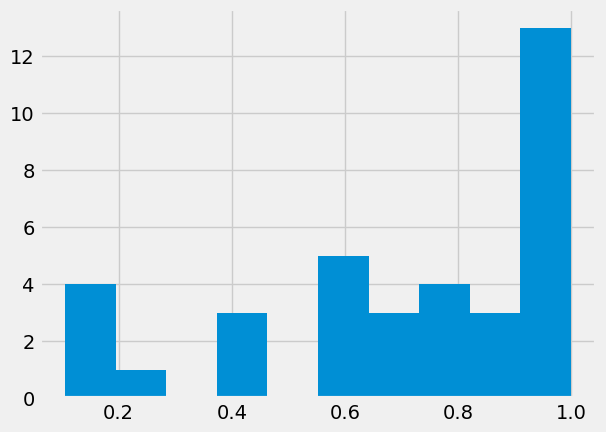

In [31]:
plt.style.use('fivethirtyeight')

y_proba = clf_final.predict_proba(X_test[cols])
y_pred = clf_final.predict(X_test[cols])

# filter only prediction that was misclassified
y_proba = y_proba[y_pred!=y_test]
#initiate array to store the difference between probabilities
diff = np.zeros((y_proba.shape[0],2))
#sort probabilities to take the difference between other's probability

y_proba =np.sort(y_proba,axis=1)
diff[:,0] = y_proba[:,2] - y_proba[:,1]
diff[:,1] = y_proba[:,2] - y_proba[:,0]
# diff array contain proximity of misclassified classes to boundary
#diff.std()

#plotting the minimum to see if misclassified classes were actually close to a different class
diff_min = diff.min(axis=1)
plt.hist(diff_min);


- From above hstogram we can see that the model incorrectly classify 9 predictions with a very high confidence. 
- This could be an indication of overfitting to some data points